In [2]:
import os
import ast
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from pydicom import dcmread
from skimage.io import imsave
from skimage.transform import resize

### Data loading

In [4]:
data_dir = '<PATH_TO_VINDR-MAMMO-DATASET>'
data = pd.read_csv(os.path.join(data_dir,'breast-level_annotations.csv'))
meta = pd.read_csv(os.path.join(data_dir,'metadata.csv'))
meta = meta.rename(columns={'SOP Instance UID': 'image_id'})
data = data.merge(meta, on='image_id')

### Data stats

In [5]:
data['breast_birads'].value_counts(normalize=False)

breast_birads
BI-RADS 1    13406
BI-RADS 2     4676
BI-RADS 3      930
BI-RADS 4      762
BI-RADS 5      226
Name: count, dtype: int64

In [6]:
data['breast_birads'].value_counts(normalize=True)

breast_birads
BI-RADS 1    0.6703
BI-RADS 2    0.2338
BI-RADS 3    0.0465
BI-RADS 4    0.0381
BI-RADS 5    0.0113
Name: proportion, dtype: float64

In [7]:
data["Manufacturer"].value_counts(normalize=False)

Manufacturer
SIEMENS              15244
Planmed               3796
IMS s.r.l.             736
IMS GIOTTO S.p.A.      224
Name: count, dtype: int64

In [8]:
data["Manufacturer"].value_counts(normalize=True)

Manufacturer
SIEMENS              0.7622
Planmed              0.1898
IMS s.r.l.           0.0368
IMS GIOTTO S.p.A.    0.0112
Name: proportion, dtype: float64

In [9]:
data["Manufacturer's Model Name"].value_counts(normalize=False)

Manufacturer's Model Name
Mammomat Inspiration    15244
Planmed Nuance           3796
GIOTTO CLASS              628
GIOTTO IMAGE 3DL          332
Name: count, dtype: int64

In [10]:
data["Manufacturer's Model Name"].value_counts(normalize=True)

Manufacturer's Model Name
Mammomat Inspiration    0.7622
Planmed Nuance          0.1898
GIOTTO CLASS            0.0314
GIOTTO IMAGE 3DL        0.0166
Name: proportion, dtype: float64

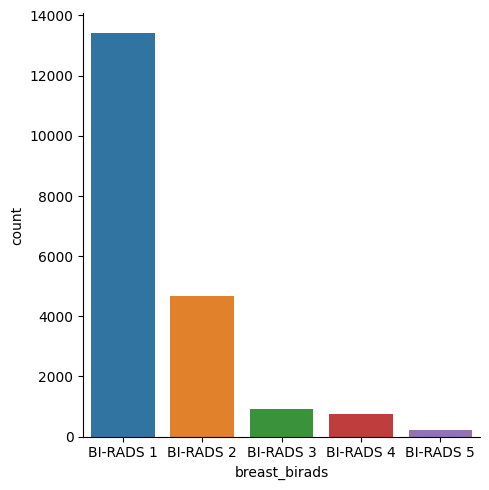

In [18]:
sns.catplot(x='breast_birads', data=data, order=['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5'], kind='count')

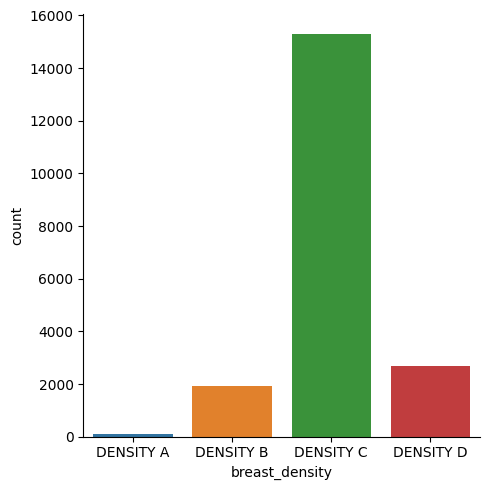

In [19]:
sns.catplot(x='breast_density', order=['DENSITY A', 'DENSITY B', 'DENSITY C', 'DENSITY D'], data=data, kind='count')

### Image preprocessing

In [25]:
image_size = (512,512)

In [83]:
preproc_dir = 'images_512x512'
out_dir = os.path.join(data_dir,preproc_dir)

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for idx, _ in enumerate(tqdm(range(len(data)), desc='Processing Data')):    
    
    out_path = os.path.join(out_dir, data.loc[idx, 'study_id'])
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    img_path = os.path.join(data_dir, 'images', data.loc[idx, 'study_id'], data.loc[idx, 'image_id'] + '.dicom')
    out_fn = os.path.join(out_path, data.loc[idx, 'image_id'] + '.png')
    
    if not os.path.exists(out_fn):

        dicom = dcmread(img_path)
        image = dicom.pixel_array
        
        window = np.array(ast.literal_eval(data.loc[idx, 'Window Width']))
        level = np.array(ast.literal_eval(data.loc[idx, 'Window Center']))

        # Multiple window/level settings for IMS Giotto images
        if data.loc[idx, "Manufacturer's Model Name"] == 'GIOTTO IMAGE 3DL' or data.loc[idx, "Manufacturer's Model Name"] == 'GIOTTO CLASS':
            window = window[0]
            level = level[0]

        # MONOCHROME1 images need special handling for inverting pixel intensities
        if data.loc[idx, 'Photometric Interpretation'] == 'MONOCHROME1':
            image[image==1] += data.loc[idx, 'Pixel Padding Value']
            level = np.max(image) - level
            image = np.max(image) - image

        # Resize image
        image = resize(image, output_shape=image_size, preserve_range=True).astype(np.float32)

        # Normalize pixel intensities, and convert to 8-bit
        image -= (level - window/2)
        image /= window
        image[image<0] = 0
        image[image>1] = 1
        image *= 255

        # Flip image with laterality equals right
        if data.loc[idx, 'laterality'] == 'R':
            image = image[:, ::-1]

        # image.tofile(os.path.join(out_path, data.loc[idx, 'image_id'] + '.dat'))
        imsave(out_fn, image.astype(np.uint8))


Processing Data: 100%|██████████| 20000/20000 [3:04:21<00:00,  1.81it/s]  
